# XMM-LSS master catalogue
## Preparation of the Subaru/XMM-Newton Deep Survey (SXDS) data

The catalogue is in `dmu0_SXDS`.

In the catalogue, we keep:

- The position;
- The stellarity;
- The aperture magnitude B, V, R, i, z (2 arcsec).
- The total magnitude B, V, R, i, z (Kron like aperture magnitude).



In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))
import datetime
print("This notebook was executed on: \n{}".format(datetime.datetime.now()))

This notebook was run with herschelhelp_internal version: 
0246c5d (Thu Jan 25 17:01:47 2018 +0000) [with local modifications]
This notebook was executed on: 
2018-02-19 15:51:17.589099


In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

from collections import OrderedDict
import os

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Column, Table, join, vstack
import numpy as np
#from numpy.core.defchararray import add

from herschelhelp_internal.flagging import  gaia_flag_column
from herschelhelp_internal.masterlist import nb_astcor_diag_plot, remove_duplicates
from herschelhelp_internal.utils import astrometric_correction, mag_to_flux
from herschelhelp_internal.masterlist import merge_catalogues, nb_merge_dist_plot

In [3]:
OUT_DIR =  os.environ.get('TMP_DIR', "./data_tmp")
try:
    os.makedirs(OUT_DIR)
except FileExistsError:
    pass

RA_COL = "sxds_ra"
DEC_COL = "sxds_dec"

## I - Column selection

For each band we have 5 independent and overlapping catalogues. We must first stack the catalogues and remove duplicates then merge the bands together.

In [4]:
#We have to import and combine the H, J and Ks catalogues separately. 
#Fluxes are given in counts sowe compute them fresh from the magnitudes

epoch = 2007 # TODO: check this

bands = ["B", "V", "R", "i", "z"]
cat_numbers = [ 1, 2, 3, 4, 5 ]

def imported_columns(band): 
    return OrderedDict({
        'NUMBER': "sxds_{}_id".format(band.lower()),
        'ra': "sxds_{}_ra".format(band.lower()),
        'dec': "sxds_{}_dec".format(band.lower()),
        'CLASS_STAR_{}'.format(band):  "sxds_{}_stellarity".format(band.lower()),
        'twoApertureMag_{}'.format(band): "m_ap_sxds_{}".format(band.lower()),
        'Err_twoApertureMag_{}'.format(band): "merr_ap_sxds_{}".format(band.lower()),
        'MAG_AUTO_{}'.format(band): "m_sxds_{}".format(band.lower()),
        'Err_MAG_AUTO_{}'.format(band): "merr_sxds_{}".format(band.lower()) 
    })



In [5]:
catalogue_B = vstack([ Table.read("../../dmu0/dmu0_SXDS/data/sxdsB{}_dr1.fits".format(1))[
                                   list(imported_columns("B"))],
                      Table.read("../../dmu0/dmu0_SXDS/data/sxdsB{}_dr1.fits".format(2))[
                                   list(imported_columns("B"))],
                      Table.read("../../dmu0/dmu0_SXDS/data/sxdsB{}_dr1.fits".format(3))[
                                   list(imported_columns("B"))],
                      Table.read("../../dmu0/dmu0_SXDS/data/sxdsB{}_dr1.fits".format(4))[
                                   list(imported_columns("B"))],
                      Table.read("../../dmu0/dmu0_SXDS/data/sxdsB{}_dr1.fits".format(5))[
                                   list(imported_columns("B"))]
                     ])
                      

for column in imported_columns("B"):
    catalogue_B[column].name = imported_columns("B")[column]

In [6]:
SORT_COLS = ['merr_ap_sxds_b']
FLAG_NAME = 'sxds_flag_cleaned_b'

nb_orig_sources = len(catalogue_B)

catalogue_B = remove_duplicates(catalogue_B, 'sxds_b_ra', 'sxds_b_dec',  sort_col=SORT_COLS, flag_name=FLAG_NAME)

nb_sources = len(catalogue_B)

print("The initial catalogue had {} sources.".format(nb_orig_sources))
print("The cleaned catalogue has {} sources ({} removed).".format(nb_sources, nb_orig_sources - nb_sources))
print("The cleaned catalogue has {} sources flagged as having been cleaned".format(np.sum(catalogue_B[FLAG_NAME])))

The initial catalogue had 940853 sources.
The cleaned catalogue has 908480 sources (32373 removed).
The cleaned catalogue has 32244 sources flagged as having been cleaned


In [7]:
catalogue_V = vstack([ Table.read("../../dmu0/dmu0_SXDS/data/sxdsV{}_dr1.fits".format(1))[
                                   list(imported_columns("V"))],
                      Table.read("../../dmu0/dmu0_SXDS/data/sxdsV{}_dr1.fits".format(2))[
                                   list(imported_columns("V"))],
                      Table.read("../../dmu0/dmu0_SXDS/data/sxdsV{}_dr1.fits".format(3))[
                                   list(imported_columns("V"))],
                      Table.read("../../dmu0/dmu0_SXDS/data/sxdsV{}_dr1.fits".format(4))[
                                   list(imported_columns("V"))],
                      Table.read("../../dmu0/dmu0_SXDS/data/sxdsV{}_dr1.fits".format(5))[
                                   list(imported_columns("V"))]
                     ])
                      

for column in imported_columns("V"):
    catalogue_V[column].name = imported_columns("V")[column]

In [8]:
SORT_COLS = ['merr_ap_sxds_v']
FLAG_NAME = 'sxds_flag_cleaned_v'

nb_orig_sources = len(catalogue_V)

catalogue_V = remove_duplicates(catalogue_V, 'sxds_v_ra', 'sxds_v_dec',  sort_col=SORT_COLS, flag_name=FLAG_NAME)

nb_sources = len(catalogue_V)

print("The initial catalogue had {} sources.".format(nb_orig_sources))
print("The cleaned catalogue has {} sources ({} removed).".format(nb_sources, nb_orig_sources - nb_sources))
print("The cleaned catalogue has {} sources flagged as having been cleaned".format(np.sum(catalogue_V[FLAG_NAME])))

The initial catalogue had 1002561 sources.
The cleaned catalogue has 970203 sources (32358 removed).
The cleaned catalogue has 32252 sources flagged as having been cleaned


In [9]:
catalogue_R = vstack([ Table.read("../../dmu0/dmu0_SXDS/data/sxdsR{}_dr1.fits".format(1))[
                                   list(imported_columns("R"))],
                      Table.read("../../dmu0/dmu0_SXDS/data/sxdsR{}_dr1.fits".format(2))[
                                   list(imported_columns("R"))],
                      Table.read("../../dmu0/dmu0_SXDS/data/sxdsR{}_dr1.fits".format(3))[
                                   list(imported_columns("R"))],
                      Table.read("../../dmu0/dmu0_SXDS/data/sxdsR{}_dr1.fits".format(4))[
                                   list(imported_columns("R"))],
                      Table.read("../../dmu0/dmu0_SXDS/data/sxdsR{}_dr1.fits".format(5))[
                                   list(imported_columns("R"))]
                     ])
                      

for column in imported_columns("R"):
    catalogue_R[column].name = imported_columns("R")[column]

In [10]:
SORT_COLS = ['merr_ap_sxds_r']
FLAG_NAME = 'sxds_flag_cleaned_r'

nb_orig_sources = len(catalogue_R)

catalogue_R = remove_duplicates(catalogue_R, 'sxds_r_ra', 'sxds_r_dec',  sort_col=SORT_COLS, flag_name=FLAG_NAME)

nb_sources = len(catalogue_R)

print("The initial catalogue had {} sources.".format(nb_orig_sources))
print("The cleaned catalogue has {} sources ({} removed).".format(nb_sources, nb_orig_sources - nb_sources))
print("The cleaned catalogue has {} sources flagged as having been cleaned".format(np.sum(catalogue_R[FLAG_NAME])))

The initial catalogue had 901094 sources.
The cleaned catalogue has 873890 sources (27204 removed).
The cleaned catalogue has 27129 sources flagged as having been cleaned


In [11]:
catalogue_i = vstack([ Table.read("../../dmu0/dmu0_SXDS/data/sxdsi{}_dr1.fits".format(1))[
                                   list(imported_columns("i"))],
                      Table.read("../../dmu0/dmu0_SXDS/data/sxdsi{}_dr1.fits".format(2))[
                                   list(imported_columns("i"))],
                      Table.read("../../dmu0/dmu0_SXDS/data/sxdsi{}_dr1.fits".format(3))[
                                   list(imported_columns("i"))],
                      Table.read("../../dmu0/dmu0_SXDS/data/sxdsi{}_dr1.fits".format(4))[
                                   list(imported_columns("i"))],
                      Table.read("../../dmu0/dmu0_SXDS/data/sxdsi{}_dr1.fits".format(5))[
                                   list(imported_columns("i"))]
                     ])
                      

for column in imported_columns("i"):
    catalogue_i[column].name = imported_columns("i")[column]

In [12]:
SORT_COLS = ['merr_ap_sxds_i']
FLAG_NAME = 'sxds_flag_cleaned_i'

nb_orig_sources = len(catalogue_i)

catalogue_i = remove_duplicates(catalogue_i, 'sxds_i_ra', 'sxds_i_dec',  sort_col=SORT_COLS, flag_name=FLAG_NAME)

nb_sources = len(catalogue_i)

print("The initial catalogue had {} sources.".format(nb_orig_sources))
print("The cleaned catalogue has {} sources ({} removed).".format(nb_sources, nb_orig_sources - nb_sources))
print("The cleaned catalogue has {} sources flagged as having been cleaned".format(np.sum(catalogue_i[FLAG_NAME])))

The initial catalogue had 899484 sources.
The cleaned catalogue has 870730 sources (28754 removed).
The cleaned catalogue has 28686 sources flagged as having been cleaned


In [13]:
catalogue_z = vstack([ Table.read("../../dmu0/dmu0_SXDS/data/sxdsz{}_dr1.fits".format(1))[
                                   list(imported_columns("z"))],
                      Table.read("../../dmu0/dmu0_SXDS/data/sxdsz{}_dr1.fits".format(2))[
                                   list(imported_columns("z"))],
                      Table.read("../../dmu0/dmu0_SXDS/data/sxdsz{}_dr1.fits".format(3))[
                                   list(imported_columns("z"))],
                      Table.read("../../dmu0/dmu0_SXDS/data/sxdsz{}_dr1.fits".format(4))[
                                   list(imported_columns("z"))],
                      Table.read("../../dmu0/dmu0_SXDS/data/sxdsz{}_dr1.fits".format(5))[
                                   list(imported_columns("z"))]
                     ])
                      

for column in imported_columns("z"):
    catalogue_z[column].name = imported_columns("z")[column]

In [14]:
SORT_COLS = ['merr_ap_sxds_z']
FLAG_NAME = 'sxds_flag_cleaned_z'

nb_orig_sources = len(catalogue_z)

catalogue_z = remove_duplicates(catalogue_z, 'sxds_z_ra', 'sxds_z_dec',  sort_col=SORT_COLS, flag_name=FLAG_NAME)

nb_sources = len(catalogue_z)

print("The initial catalogue had {} sources.".format(nb_orig_sources))
print("The cleaned catalogue has {} sources ({} removed).".format(nb_sources, nb_orig_sources - nb_sources))
print("The cleaned catalogue has {} sources flagged as having been cleaned".format(np.sum(catalogue_z[FLAG_NAME])))

The initial catalogue had 842590 sources.
The cleaned catalogue has 818902 sources (23688 removed).
The cleaned catalogue has 23589 sources flagged as having been cleaned


## Merging different bands
SXDS has indivdual extractions from each band. We must therefore merge them as if they were individual catalogues (they have different

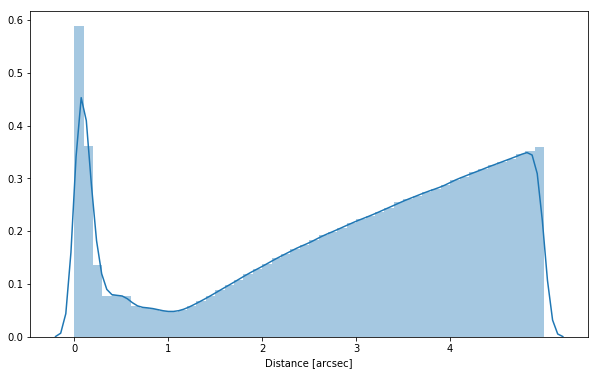

In [15]:
nb_merge_dist_plot(
    SkyCoord(catalogue_B['sxds_b_ra'], catalogue_B['sxds_b_dec']),
    SkyCoord(catalogue_V['sxds_v_ra'], catalogue_V['sxds_v_dec'])
)

In [16]:
catalogue = catalogue_B
catalogue_B['sxds_b_ra'].name = 'ra'
catalogue_B['sxds_b_dec'].name = 'dec'
# Given the graph above, we use 0.8 arc-second radius
catalogue = merge_catalogues(catalogue, catalogue_V, "sxds_v_ra", "sxds_v_dec", radius=0.8*u.arcsec)
del catalogue_B
del catalogue_V

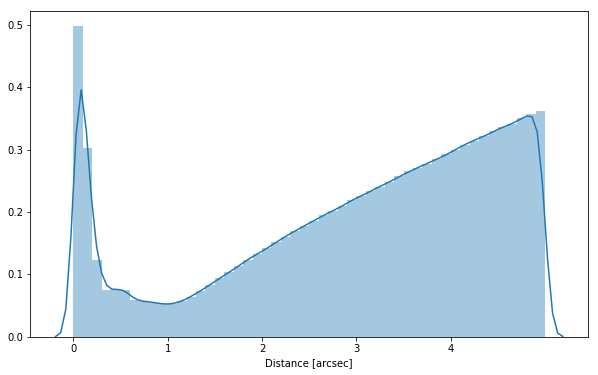

In [17]:
nb_merge_dist_plot(
    SkyCoord(catalogue['ra'], catalogue['dec']),
    SkyCoord(catalogue_R['sxds_r_ra'], catalogue_R['sxds_r_dec'])
)

In [18]:
catalogue = merge_catalogues(catalogue, catalogue_R, "sxds_r_ra", "sxds_r_dec", radius=0.8*u.arcsec)
del catalogue_R

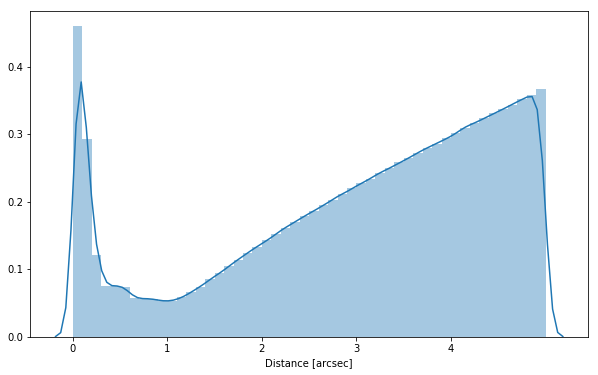

In [19]:
nb_merge_dist_plot(
    SkyCoord(catalogue['ra'], catalogue['dec']),
    SkyCoord(catalogue_i['sxds_i_ra'], catalogue_i['sxds_i_dec'])
)

In [20]:
catalogue = merge_catalogues(catalogue, catalogue_i, "sxds_i_ra", "sxds_i_dec", radius=0.8*u.arcsec)
del catalogue_i

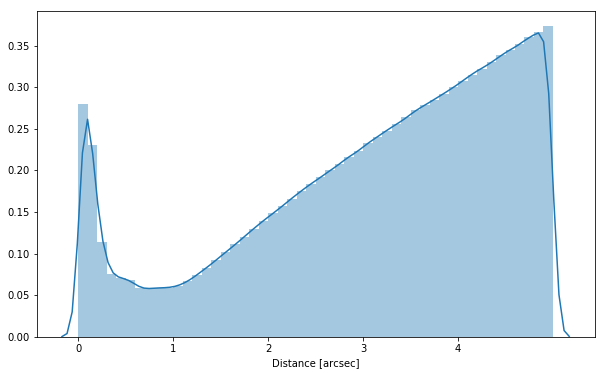

In [21]:
nb_merge_dist_plot(
    SkyCoord(catalogue['ra'], catalogue['dec']),
    SkyCoord(catalogue_z['sxds_z_ra'], catalogue_z['sxds_z_dec'])
)

In [22]:
catalogue = merge_catalogues(catalogue, catalogue_z, "sxds_z_ra", "sxds_z_dec", radius=0.8*u.arcsec)
del catalogue_z

In [23]:
#rename radec colums
catalogue['ra'].name = 'sxds_ra'
catalogue['dec'].name = 'sxds_dec'

## Fill masked values and add fluxes and nans

In [24]:
for col in catalogue.colnames:
    if "m_" in col or "merr_" in col or "f_" in col or "ferr_" in col or "stellarity" in col:
        catalogue[col].fill_value = np.nan
    elif "flag" in col:
        catalogue[col].fill_value = 0
    elif "id" in col:
        catalogue[col].fill_value = ""
        
catalogue =  catalogue.filled()

In [25]:

for col in catalogue.colnames:
    if col.startswith('m_'):
        
        errcol = "merr{}".format(col[1:])
        # catalogue_h[col].name = imported_columns_h[col]
        
        # Turn 99.0 and 99.03 to nans
        catalogue[col][catalogue[col] > 90.] = np.nan
        catalogue[errcol][catalogue[errcol] > 90.] = np.nan 
    
        flux, error = mag_to_flux(np.array(catalogue[col]), np.array(catalogue[errcol]))
        
        # Fluxes are added in µJy
        catalogue.add_column(Column(flux * 1.e6, name="f{}".format(col[1:])))
        catalogue.add_column(Column(error * 1.e6, name="f{}".format(errcol[1:])))

        # Band-flag column
        if "ap" not in col:
            catalogue.add_column(Column(np.zeros(len(catalogue), dtype=bool), name="flag{}".format(col[1:])))
        
# Clean table metadata
catalogue.meta = None
    


/opt/anaconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in greater
/opt/anaconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in greater


In [26]:
catalogue[:10].show_in_notebook()

idx,sxds_b_id,sxds_ra,sxds_dec,sxds_b_stellarity,m_ap_sxds_b,merr_ap_sxds_b,m_sxds_b,merr_sxds_b,sxds_flag_cleaned_b,flag_merged,sxds_v_id,sxds_v_stellarity,m_ap_sxds_v,merr_ap_sxds_v,m_sxds_v,merr_sxds_v,sxds_flag_cleaned_v,sxds_r_id,sxds_r_stellarity,m_ap_sxds_r,merr_ap_sxds_r,m_sxds_r,merr_sxds_r,sxds_flag_cleaned_r,sxds_i_id,sxds_i_stellarity,m_ap_sxds_i,merr_ap_sxds_i,m_sxds_i,merr_sxds_i,sxds_flag_cleaned_i,sxds_z_id,sxds_z_stellarity,m_ap_sxds_z,merr_ap_sxds_z,m_sxds_z,merr_sxds_z,sxds_flag_cleaned_z,f_ap_sxds_b,ferr_ap_sxds_b,f_sxds_b,ferr_sxds_b,flag_sxds_b,f_ap_sxds_v,ferr_ap_sxds_v,f_sxds_v,ferr_sxds_v,flag_sxds_v,f_ap_sxds_r,ferr_ap_sxds_r,f_sxds_r,ferr_sxds_r,flag_sxds_r,f_ap_sxds_i,ferr_ap_sxds_i,f_sxds_i,ferr_sxds_i,flag_sxds_i,f_ap_sxds_z,ferr_ap_sxds_z,f_sxds_z,ferr_sxds_z,flag_sxds_z
,,deg,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,SXDS-BS-080266,34.2020416667,-5.42370277778,0.85,18.7285,0.0004,14.2769,0.0001,False,False,,nan,nan,nan,nan,nan,False,,nan,nan,nan,nan,nan,False,,nan,nan,nan,nan,nan,False,,nan,nan,nan,nan,nan,False,117.111623075,0.0431455164016,7067.07987639,0.650902110975,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False
1,SXDS-BE-073140,34.9161291667,-4.78265,0.85,18.7115,0.0004,14.8626,0.0001,False,False,,nan,nan,nan,nan,nan,False,,nan,nan,nan,nan,nan,False,,nan,nan,nan,nan,nan,False,,nan,nan,nan,nan,nan,False,118.95973827,0.0438263872012,4120.59565261,0.379520884958,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False
2,SXDS-BE-094119,34.9513791667,-4.73448333333,0.85,18.731,0.0004,13.9633,0.0,False,False,,nan,nan,nan,nan,nan,False,,nan,nan,nan,nan,nan,False,,nan,nan,nan,nan,nan,False,,nan,nan,nan,nan,nan,False,116.842273817,0.0430462844675,9433.65522735,0.0,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False
3,SXDS-BS-055523,34.2651083333,-5.48383611111,0.85,18.7704,0.0004,14.767,0.0001,False,False,,nan,nan,nan,nan,nan,False,,nan,nan,nan,nan,nan,False,,nan,nan,nan,nan,nan,False,,nan,nan,nan,nan,nan,False,112.678225777,0.0415121924768,4499.87033872,0.414453374494,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False
4,SXDS-BW-155711,33.8873791667,-4.79510555556,0.96,18.4466,0.0004,17.3057,0.0002,False,False,,nan,nan,nan,nan,nan,False,,nan,nan,nan,nan,nan,False,,nan,nan,nan,nan,nan,False,,nan,nan,nan,nan,nan,False,151.830841833,0.0559365492897,434.230175364,0.0799881542977,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False
5,SXDS-BE-095751,34.9587208333,-5.20841666667,0.85,18.745,0.0004,13.6014,0.0,False,False,,nan,nan,nan,nan,nan,False,,nan,nan,nan,nan,nan,False,,nan,nan,nan,nan,nan,False,,nan,nan,nan,nan,nan,False,115.345325782,0.0424947884308,13165.5801095,0.0,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False
6,SXDS-BC-053580,34.2495416667,-5.07456666667,0.88,18.8177,0.0004,16.1009,0.0001,False,False,,nan,nan,nan,nan,nan,False,,nan,nan,nan,nan,nan,False,,nan,nan,nan,nan,nan,False,,nan,nan,nan,nan,nan,False,107.87479912,0.0397425446983,1317.16444794,0.121315328914,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False
7,SXDS-BW-151062,33.8860208333,-4.79550833333,0.71,18.5116,0.0004,16.9447,0.0002,False,False,,nan,nan,nan,nan,nan,False,,nan,nan,nan,nan,nan,False,,nan,nan,nan,nan,nan,False,,nan,nan,nan,nan,nan,False,143.007890354,0.0526860538414,605.508159729,0.111538724982,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False
8,SXDS-BN-148126,34.6976416667,-4.39313055556,0.85,18.7245,0.0004,13.7238,0.0,False,False,,nan,nan,nan,nan,nan,False,,nan,nan,nan,nan,nan,False,,nan,nan,nan,nan,nan,False,,nan,nan,nan,nan,nan,False,117.543873986,0.0433047635221,11761.9681757,0.0,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,nan,n

## Combine stellarities

In [27]:
stellarity_columns = [column for column in catalogue.colnames
                      if 'stellarity' in column]

print(", ".join(stellarity_columns))

sxds_b_stellarity, sxds_v_stellarity, sxds_r_stellarity, sxds_i_stellarity, sxds_z_stellarity


In [28]:
# We create an masked array with all the stellarities and get the maximum value, as well as its
# origin.  Some sources may not have an associated stellarity.
stellarity_array = np.array([catalogue[column] for column in stellarity_columns])
stellarity_array = np.ma.masked_array(stellarity_array, np.isnan(stellarity_array))

max_stellarity = np.max(stellarity_array, axis=0)
max_stellarity.fill_value = np.nan

catalogue.add_column(Column(data=max_stellarity.filled(), name="sxds_stellarity"))

catalogue.remove_columns(stellarity_columns)

In [29]:
catalogue[:10].show_in_notebook()

idx,sxds_b_id,sxds_ra,sxds_dec,m_ap_sxds_b,merr_ap_sxds_b,m_sxds_b,merr_sxds_b,sxds_flag_cleaned_b,flag_merged,sxds_v_id,m_ap_sxds_v,merr_ap_sxds_v,m_sxds_v,merr_sxds_v,sxds_flag_cleaned_v,sxds_r_id,m_ap_sxds_r,merr_ap_sxds_r,m_sxds_r,merr_sxds_r,sxds_flag_cleaned_r,sxds_i_id,m_ap_sxds_i,merr_ap_sxds_i,m_sxds_i,merr_sxds_i,sxds_flag_cleaned_i,sxds_z_id,m_ap_sxds_z,merr_ap_sxds_z,m_sxds_z,merr_sxds_z,sxds_flag_cleaned_z,f_ap_sxds_b,ferr_ap_sxds_b,f_sxds_b,ferr_sxds_b,flag_sxds_b,f_ap_sxds_v,ferr_ap_sxds_v,f_sxds_v,ferr_sxds_v,flag_sxds_v,f_ap_sxds_r,ferr_ap_sxds_r,f_sxds_r,ferr_sxds_r,flag_sxds_r,f_ap_sxds_i,ferr_ap_sxds_i,f_sxds_i,ferr_sxds_i,flag_sxds_i,f_ap_sxds_z,ferr_ap_sxds_z,f_sxds_z,ferr_sxds_z,flag_sxds_z,sxds_stellarity
,,deg,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,SXDS-BS-080266,34.2020416667,-5.42370277778,18.7285,0.0004,14.2769,0.0001,False,False,,nan,nan,nan,nan,False,,nan,nan,nan,nan,False,,nan,nan,nan,nan,False,,nan,nan,nan,nan,False,117.111623075,0.0431455164016,7067.07987639,0.650902110975,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,0.85
1,SXDS-BE-073140,34.9161291667,-4.78265,18.7115,0.0004,14.8626,0.0001,False,False,,nan,nan,nan,nan,False,,nan,nan,nan,nan,False,,nan,nan,nan,nan,False,,nan,nan,nan,nan,False,118.95973827,0.0438263872012,4120.59565261,0.379520884958,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,0.85
2,SXDS-BE-094119,34.9513791667,-4.73448333333,18.731,0.0004,13.9633,0.0,False,False,,nan,nan,nan,nan,False,,nan,nan,nan,nan,False,,nan,nan,nan,nan,False,,nan,nan,nan,nan,False,116.842273817,0.0430462844675,9433.65522735,0.0,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,0.85
3,SXDS-BS-055523,34.2651083333,-5.48383611111,18.7704,0.0004,14.767,0.0001,False,False,,nan,nan,nan,nan,False,,nan,nan,nan,nan,False,,nan,nan,nan,nan,False,,nan,nan,nan,nan,False,112.678225777,0.0415121924768,4499.87033872,0.414453374494,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,0.85
4,SXDS-BW-155711,33.8873791667,-4.79510555556,18.4466,0.0004,17.3057,0.0002,False,False,,nan,nan,nan,nan,False,,nan,nan,nan,nan,False,,nan,nan,nan,nan,False,,nan,nan,nan,nan,False,151.830841833,0.0559365492897,434.230175364,0.0799881542977,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,0.96
5,SXDS-BE-095751,34.9587208333,-5.20841666667,18.745,0.0004,13.6014,0.0,False,False,,nan,nan,nan,nan,False,,nan,nan,nan,nan,False,,nan,nan,nan,nan,False,,nan,nan,nan,nan,False,115.345325782,0.0424947884308,13165.5801095,0.0,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,0.85
6,SXDS-BC-053580,34.2495416667,-5.07456666667,18.8177,0.0004,16.1009,0.0001,False,False,,nan,nan,nan,nan,False,,nan,nan,nan,nan,False,,nan,nan,nan,nan,False,,nan,nan,nan,nan,False,107.87479912,0.0397425446983,1317.16444794,0.121315328914,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,0.88
7,SXDS-BW-151062,33.8860208333,-4.79550833333,18.5116,0.0004,16.9447,0.0002,False,False,,nan,nan,nan,nan,False,,nan,nan,nan,nan,False,,nan,nan,nan,nan,False,,nan,nan,nan,nan,False,143.007890354,0.0526860538414,605.508159729,0.111538724982,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,0.71
8,SXDS-BN-148126,34.6976416667,-4.39313055556,18.7245,0.0004,13.7238,0.0,False,False,,nan,nan,nan,nan,False,,nan,nan,nan,nan,False,,nan,nan,nan,nan,False,,nan,nan,nan,nan,False,117.543873986,0.0433047635221,11761.9681757,0.0,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,0.85


## II - Removal of duplicated sources

We remove duplicated objects from the input catalogues.

In [30]:
SORT_COLS = ['merr_ap_sxds_b',
            'merr_ap_sxds_v',
            'merr_ap_sxds_r',
            'merr_ap_sxds_i',
            'merr_ap_sxds_z',]
FLAG_NAME = 'sxds_flag_cleaned'

nb_orig_sources = len(catalogue)

catalogue = remove_duplicates(catalogue, RA_COL, DEC_COL, sort_col=SORT_COLS,flag_name=FLAG_NAME)

nb_sources = len(catalogue)

print("The initial catalogue had {} sources.".format(nb_orig_sources))
print("The cleaned catalogue has {} sources ({} removed).".format(nb_sources, nb_orig_sources - nb_sources))
print("The cleaned catalogue has {} sources flagged as having been cleaned".format(np.sum(catalogue[FLAG_NAME])))

The initial catalogue had 1522678 sources.
The cleaned catalogue has 1512687 sources (9991 removed).
The cleaned catalogue has 10007 sources flagged as having been cleaned


In [31]:
catalogue['sxds_flag_cleaned'] =  (catalogue['sxds_flag_cleaned'] | 
                                   catalogue['sxds_flag_cleaned_b'] |  
                                   catalogue['sxds_flag_cleaned_v'] | 
                                   catalogue['sxds_flag_cleaned_r'] | 
                                   catalogue['sxds_flag_cleaned_i'] |  
                                   catalogue['sxds_flag_cleaned_z'])

In [32]:
catalogue.remove_columns(['sxds_flag_cleaned_b',
                         'sxds_flag_cleaned_v',
                         'sxds_flag_cleaned_r',
                         'sxds_flag_cleaned_i',
                         'sxds_flag_cleaned_z'])
catalogue['flag_merged'].name = 'sxds_flag_merged'

In [33]:
catalogue[:10].show_in_notebook()

idx,sxds_b_id,sxds_ra,sxds_dec,m_ap_sxds_b,merr_ap_sxds_b,m_sxds_b,merr_sxds_b,sxds_flag_merged,sxds_v_id,m_ap_sxds_v,merr_ap_sxds_v,m_sxds_v,merr_sxds_v,sxds_r_id,m_ap_sxds_r,merr_ap_sxds_r,m_sxds_r,merr_sxds_r,sxds_i_id,m_ap_sxds_i,merr_ap_sxds_i,m_sxds_i,merr_sxds_i,sxds_z_id,m_ap_sxds_z,merr_ap_sxds_z,m_sxds_z,merr_sxds_z,f_ap_sxds_b,ferr_ap_sxds_b,f_sxds_b,ferr_sxds_b,flag_sxds_b,f_ap_sxds_v,ferr_ap_sxds_v,f_sxds_v,ferr_sxds_v,flag_sxds_v,f_ap_sxds_r,ferr_ap_sxds_r,f_sxds_r,ferr_sxds_r,flag_sxds_r,f_ap_sxds_i,ferr_ap_sxds_i,f_sxds_i,ferr_sxds_i,flag_sxds_i,f_ap_sxds_z,ferr_ap_sxds_z,f_sxds_z,ferr_sxds_z,flag_sxds_z,sxds_stellarity,sxds_flag_cleaned
,,deg,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,SXDS-BC-195550,34.79535,-4.78773055556,18.143,0.0003,17.706,0.0003,False,SXDS-VC-210083,17.8143,0.0005,16.8643,0.0003,SXDS-RC-162063,17.7057,0.0003,16.2258,0.0002,SXDS-iC-153865,17.3312,0.0003,15.4783,0.0001,SXDS-zC-151811,15.784,0.0002,14.691,0.0001,200.816780418,0.0554877270017,300.330887868,0.0829844910444,False,271.819118665,0.125177330126,652.048649872,0.180167700132,False,300.413883824,0.0830074236747,1174.03217728,0.216264719209,False,424.150516314,0.117197118726,2337.11455443,0.215256205346,False,1763.5996339,0.324867058162,4826.14093269,0.444504006732,False,0.99,False
1,SXDS-BN-173347,34.7773583333,-4.37012222222,17.9451,0.0003,17.2433,0.0002,False,SXDS-VN-172778,17.8615,0.0005,16.4521,0.0002,SXDS-RN-152786,17.7613,0.0003,15.8741,0.0001,SXDS-iN-153336,17.4038,0.0003,15.4561,0.0001,SXDS-zN-141944,15.6427,0.0003,14.6932,0.0002,240.968347842,0.0665820150748,459.917568915,0.0847199470551,False,260.255550183,0.119852110044,953.147251771,0.175576212269,False,285.417107132,0.0788636611402,1623.15502278,0.149498102363,False,396.716259052,0.109616753309,2385.39332697,0.219702844624,False,2008.72275812,0.555030609457,4816.37174541,0.887208462664,False,0.96,False
2,SXDS-BN-151757,34.7995416667,-4.39339722222,17.9631,0.0003,16.8611,0.0002,False,SXDS-VN-158507,17.8667,0.0005,16.2048,0.0002,SXDS-RN-139009,17.7489,0.0003,15.7209,0.0001,SXDS-iN-141453,17.4034,0.0003,15.4785,0.0001,SXDS-zN-135277,15.6914,0.0003,14.8298,0.0002,237.006359815,0.0654872773266,653.973273511,0.120466328864,False,259.012068367,0.119279465505,1196.96099937,0.220488364323,False,288.695490408,0.0797695119153,1869.13211715,0.172153429992,False,396.862441649,0.109657145053,2336.68408167,0.21521655734,False,1920.61360085,0.530685149605,4246.97788965,0.782322238319,False,0.97,False
3,SXDS-BE-177175,35.1538291667,-5.29775277778,18.0304,0.0003,17.5633,0.0003,False,SXDS-VE-189575,17.8977,0.0005,17.2641,0.0004,SXDS-RE-152906,17.7998,0.0003,17.0924,0.0002,SXDS-iE-173034,17.4825,0.0003,17.0055,0.0003,SXDS-zE-139283,16.8482,0.0004,16.6507,0.0004,222.761431463,0.0615512581658,342.515318932,0.0946404800993,False,251.721319724,0.115921951677,451.190555245,0.166224743457,False,275.473609775,0.0761161712856,528.493925623,0.0973521787902,False,368.97759857,0.101952278174,572.532309394,0.158196523304,False,661.789694546,0.243812333657,793.816277439,0.292452724321,False,1.0,False
4,SXDS-BE-177375,35.13665,-5.30048611111,18.0121,0.0003,17.3866,0.0002,False,SXDS-VE-185580,17.933,0.0005,17.0392,0.0003,SXDS-RE-167157,17.8112,0.0003,16.8232,0.0002,SXDS-iE-163094,17.3933,0.0003,16.7114,0.0002,SXDS-zE-140119,16.5035,0.0004,16.2767,0.0003,226.54787871,0.0625974922039,403.050997209,0.0742447374311,False,243.668842346,0.112213648803,555.03452688,0.153361707323,False,272.596327129,0.0753211487101,677.204756792,0.124745726232,False,400.571456906,0.110681983842,750.654340226,0.138275639504,False,909.07559736,0.334915827022,1120.26301974,0.309540111537,False,1.0,False
5,SXDS-BW-159933,33.8836083333,-4.72996111111,18.0641,0.0003,16.3671,0.0001,False,SXDS-VW-163032,18.0244,0.0005,16.1426,0.0002,SXDS-RW-145440,17.9471,0.0004,15.9421,0.0001,SXDS-iW-138205,17.5495,0.0003,15.8556,0.0002,SXDS-zW-135978,16.0227,0.0003,15.3752,0.0002,215.953377112,0.0596701232303,1030.76579865,0.09493703849

## III - Astrometry correction

We match the astrometry to the Gaia one. We limit the Gaia catalogue to sources with a g band flux between the 30th and the 70th percentile. Some quick tests show that this give the lower dispersion in the results.

In [34]:
gaia = Table.read("../../dmu0/dmu0_GAIA/data/GAIA_XMM-LSS.fits")
gaia_coords = SkyCoord(gaia['ra'], gaia['dec'])

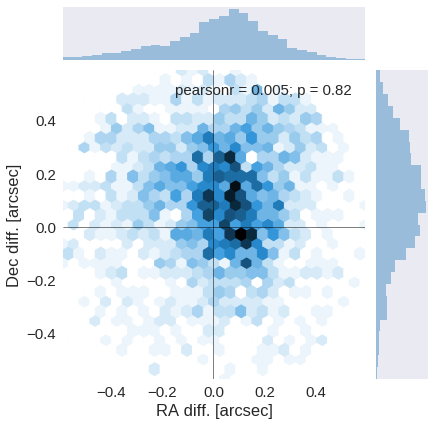

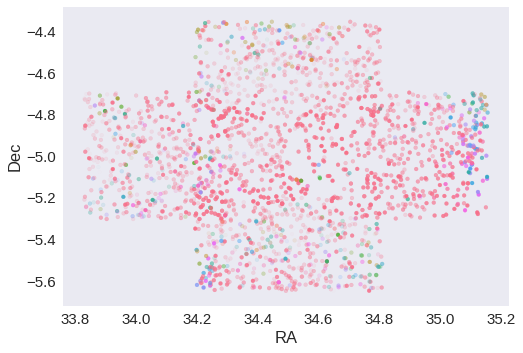

In [35]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec)

In [36]:
delta_ra, delta_dec =  astrometric_correction(
    SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]),
    gaia_coords
)

print("RA correction: {}".format(delta_ra))
print("Dec correction: {}".format(delta_dec))

RA correction: -0.050656639996304875 arcsec
Dec correction: -0.1055842856297673 arcsec


In [37]:
catalogue[RA_COL] = catalogue[RA_COL] + delta_ra.to(u.deg)
catalogue[DEC_COL] = catalogue[DEC_COL] + delta_dec.to(u.deg)

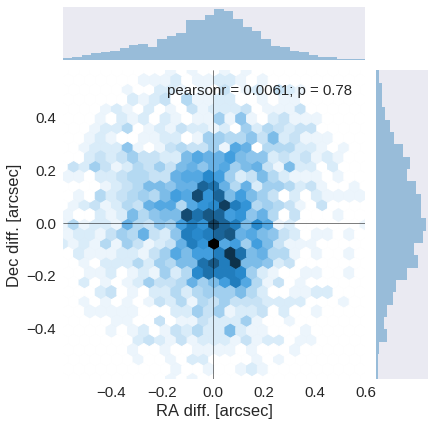

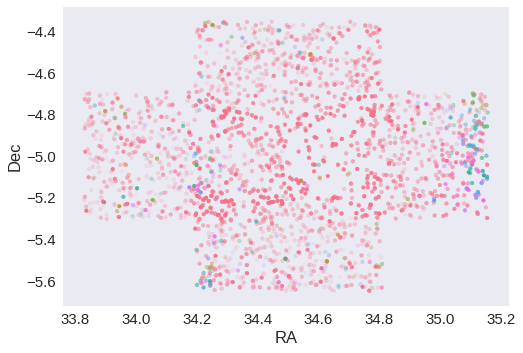

In [38]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec)

## IV - Flagging Gaia objects

In [39]:
catalogue.add_column(
    gaia_flag_column(SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]), epoch, gaia)
)

In [40]:
GAIA_FLAG_NAME = "sxds_flag_gaia"

catalogue['flag_gaia'].name = GAIA_FLAG_NAME
print("{} sources flagged.".format(np.sum(catalogue[GAIA_FLAG_NAME] > 0)))

2954 sources flagged.


In [41]:
catalogue.add_column(Column(data=np.arange(len(catalogue)), name="sxds_intid"))

In [42]:
for col in catalogue.colnames:
    if col.endswith('_sxds_b'):
        catalogue.rename_column(col, col.replace('_sxds_b', '_sxds-suprime_b'))
    elif col.endswith('_sxds_v'):
        catalogue.rename_column(col, col.replace('_sxds_v', '_sxds-suprime_v'))
    elif col.endswith('_sxds_r'):
        catalogue.rename_column(col, col.replace('_sxds_r', '_sxds-suprime_rc'))
    elif col.endswith('_sxds_i'):
        catalogue.rename_column(col, col.replace('_sxds_i', '_sxds-suprime_ip'))
    elif col.endswith('_sxds_z'):
        catalogue.rename_column(col, col.replace('_sxds_z', '_sxds-suprime_zp'))

# V - Saving to disk

In [43]:
catalogue.write("{}/SXDS.fits".format(OUT_DIR), overwrite=True)